# Goal of notebook
prep objects for cell2location 

# load mdoules 

In [1]:
import scanpy as sc
import scvi
import anndata as an
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location as c2l
import scvi

from matplotlib import rcParams

import scanpy as sc
import muon as mu
import os 

/projects/home/plopez29/cell2location/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Filter out misc cells in adata obj 

In [2]:
os.chdir("/projects/Pregnancy_placenta/Results/10_Merging_all_batches/")

In [3]:
adata = mu.read("Batches1-15_V11.h5mu")

In [9]:
# Step 1: Transfer .raw to .X (this is fast)
adata["GEX"].X = adata["GEX"].raw.X
adata["GEX"].raw = None  # Optional: clears memory


In [10]:
adata_nona  = adata["GEX"][~adata["GEX"].obs["sub_lin2"].isin(["nan"])].copy()

In [11]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/ref_data")
adata_nona.write_h5ad("Batches1-15_V11_nona.h5ad")

# Prep spatial object 

## Load obj 

In [3]:
os.chdir("/projects/Pregnancy_placenta/Results/")
TMA_obj = an.read_h5ad("14_visium_deconvolution/visium_data/TMA_merged_V1.h5ad")

## fix ensemble id to be var name 

In [7]:
TMA_obj.var["feature_name"] = TMA_obj.var_names
TMA_obj.var.set_index("gene_ids", drop=True, inplace=True)

In [8]:
TMA_obj.var.head()

,feature_name
gene_ids,
ENSG00000187634,SAMD11
ENSG00000188976,NOC2L
ENSG00000187961,KLHL17
ENSG00000187583,PLEKHN1
ENSG00000187642,PERM1


## find mitochondrial genes 

In [9]:
# find mitochondrial (MT) genes
TMA_obj.var["MT_gene"] = [
    gene.startswith("MT-") for gene in TMA_obj.var["feature_name"]
]

# remove MT genes for spatial mapping (keeping their counts in the object)
TMA_obj.obsm["MT"] = TMA_obj[:, TMA_obj.var["MT_gene"].values].X.toarray()
TMA_obj = TMA_obj[:, ~TMA_obj.var["MT_gene"].values]

## save obj 

In [11]:
TMA_obj.write_h5ad("14_visium_deconvolution/visium_data/TMA_merged_V2.h5ad")

# Prep scRNAseq Obj 

## Load obj  - SC

In [12]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/ref_data")
sc_obj = an.read_h5ad("Batches1-15_V11_nona.h5ad")

## Load obj - Spatial 

In [ ]:
os.chdir("/projects/Pregnancy_placenta/Results/")
TMA_obj.write_h5ad("14_visium_deconvolution/visium_data/TMA_merged_V2.h5ad")

## fix ensemble

In [13]:
sc_obj.var

,n_cells,percent_cells,robust,highly_variable_features,mean,var,hvf_loess,hvf_rank
G:MIR1302-2HG,18,0.001358,False,False,0.000053,0.000246,0.000000,-1
G:AL627309.1,1394,0.105164,True,False,0.003851,0.016454,0.017135,22919
G:AL627309.3,188,0.014183,False,False,0.000512,0.002225,0.000000,-1
G:AL627309.5,7096,0.535325,True,False,0.021378,0.098194,0.093330,8450
G:AL627309.4,25,0.001886,False,False,0.000082,0.000392,0.000000,-1
...,...,...,...,...,...,...,...,...
G:AC141272.1,54,0.004074,False,False,0.000207,0.001229,0.000000,-1
G:AC023491.2,24,0.001811,False,False,0.000070,0.000313,0.000000,-1
G:AC007325.1,329,0.024820,False,False,0.000967,0.004369,0.000000,-1
G:AC007325.4,1565,0.118064,True,False,0.004400,0.019459,0.019501,15799


In [14]:
# Step 1: Remove 'G:' from var_names
sc_obj.var_names = sc_obj.var_names.str.replace('^G:', '', regex=True)

# Step 2: Create a mapping from TMA_obj (assuming gene symbols are unique)
# 'feature_name' column holds gene symbols, index is Ensembl ID
gene_map = TMA_obj.var.reset_index().set_index('feature_name')

# Step 3: Map gene symbols to Ensembl IDs
sc_obj.var['feature_name'] = sc_obj.var_names  # preserve gene symbol
sc_obj.var['gene_ids'] = sc_obj.var_names.map(gene_map['gene_ids'])

# Step 4: Drop entries where no match is found (optional)
sc_obj = sc_obj[:, sc_obj.var['gene_ids'].notna()].copy()

# Step 5: Set Ensembl ID as index and drop the old index
sc_obj.var.set_index('gene_ids', drop=True, inplace=True)

# Result: sc_obj.var has Ensembl IDs as index and gene symbols as 'feature_name'


In [16]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/ref_data")
sc_obj.write_h5ad("Batches1-15_V11_nona_V2.h5ad")#%%
# subset to just a few cells

# Find shared genes 

## Load obj - sc

In [2]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/ref_data")
sc_obj = an.read_h5ad("Batches1-15_V11_nona_V2.h5ad")#%%
# subset to just a few cells

## Load obj - spatial 

In [3]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/visium_data")
TMA_obj = an.read_h5ad("TMA_merged_V2.h5ad")

## iterate through both objects 

In [4]:
shared_features = [
    feature for feature in TMA_obj.var_names if feature in sc_obj.var_names
]


In [5]:
len(shared_features)

17872

## subset obj 

In [6]:
sc_obj = sc_obj[:, shared_features].copy()
TMA_obj = TMA_obj[:, shared_features].copy()

## save obj 

In [7]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/ref_data")
sc_obj.write_h5ad("Batches1-15_V11_nona_V3.h5ad")#%%
# subset to just a few cells

In [8]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/visium_data")
TMA_obj.write_h5ad("TMA_merged_V3.h5ad")

# Filter genes using c2l function 

## Load obj - scRNAseq

In [ ]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/ref_data")
sc_obj = an.read_h5ad("Batches1-15_V11_nona_V3.h5ad")#%%
# subset to just a few cells

## Load obj - spatial 

In [ ]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/visium_data")
TMA_obj = an.read_h5ad("TMA_merged_V3.h5ad")

## filter genes

/projects/home/plopez29/cell2location/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


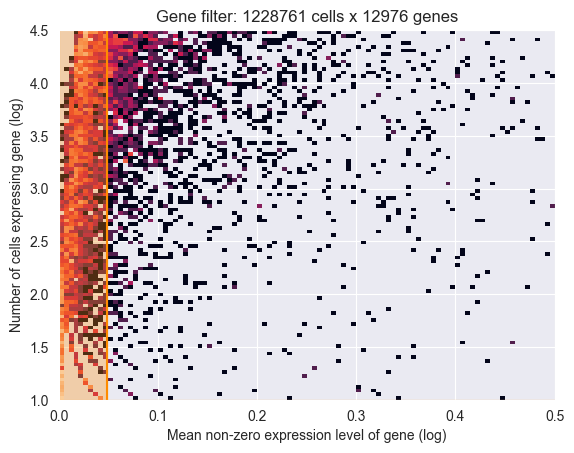

In [9]:
selected = c2l.utils.filtering.filter_genes(
    sc_obj, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12
)

In [10]:
len(selected)

12976

## subset obj 

In [11]:
sc_obj = sc_obj[:, selected].copy()
TMA_obj = TMA_obj[:, selected].copy()

## save obj - sc

In [12]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/ref_data")
sc_obj.write_h5ad("Batches1-15_V11_nona_V4.h5ad")#%%
# subset to just a few cells

## save obj - spatial 

In [13]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution/visium_data")
TMA_obj.write_h5ad("TMA_merged_V4.h5ad")

In [19]:
TMA_obj

AnnData object with n_obs × n_vars = 317507 × 12976
    obs: 'in_tissue', 'array_row', 'array_col', 'location_id', 'region', 'Row_num', 'Tissue_core', 'Patient', 'Condition', 'TMA_num', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'feature_name', 'MT_gene'
    obsm: 'MT', 'spatial'

# Calculate average of each genes 

## Test 1 - using sublin2

In [22]:
from cell2location.cluster_averages import cluster_averages

In [29]:
df_avg_sublin2 = cluster_averages.compute_cluster_averages(sc_obj,labels = "sub_lin2",use_raw=False)

In [34]:
os.chdir("/projects/Pregnancy_placenta/Results/14_visium_deconvolution")
df_avg_sublin2.to_csv("0_infered_cell_abundance_scRNA/inf_abund_scRNA_sublin2_V1.csv")#%%




In [ ]:
plot_spatial(
        adata=slide, 
        # labels to show on a plot
        color=clust_col, labels=clust_labels, 
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast', 
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6, 
        colorbar_position='right'
    )

In [ ]:
b# ignore

In [33]:
import numpy as np
import pandas as pd
import scanpy as sc

def stratified_subsample(adata, obs_column, target_n=300_000, random_state=0):
    """
    Downsample AnnData to `target_n` cells, preserving proportions in `obs_column`.
    
    Parameters:
        adata (AnnData): Input AnnData object.
        obs_column (str): Name of the column in `adata.obs` to stratify by.
        target_n (int): Total number of cells to retain.
        random_state (int): Seed for reproducibility.
    
    Returns:
        AnnData: Downsampled AnnData object.
    """
    # Get value counts and compute how many to sample per group
    counts = adata.obs[obs_column].value_counts(normalize=True)
    n_per_group = (counts * target_n).round().astype(int)

    # Collect sampled indices for each group
    sampled_indices = []
    for group, n in n_per_group.items():
        group_indices = adata.obs[adata.obs[obs_column] == group].index
        sampled = np.random.RandomState(seed=random_state).choice(group_indices, size=n, replace=False)
        sampled_indices.extend(sampled)

    return adata[sampled_indices].copy()

# Example usage:
#adata_subsampled = stratified_subsample(adata["GEX"], obs_column="sub_lin2", target_n=300_000)


KeyboardInterrupt: 

In [11]:
adata["GEX"].obs.loc[is.na(adata["GEX"].obs['sub_lin2']),;].copy()

SyntaxError: invalid syntax (1068729423.py, line 1)

In [31]:
adata["GEX"].layers["raw"] = adata["GEX"].raw.X.copy()

KeyboardInterrupt: 

In [ ]:
adata["GEX"]

In [ ]:
sc.pl.umap(adata["GEX"],color = "sub_lin2",use_raw=False)

In [20]:
adata["GEX"].obs['sub_lin2'].value_counts()

sub_lin2
HBC_1                82025
VCT_1                71845
HBC_2_CXCL2_CXCL3    67940
VCT_2                64422
VCT_3                50386
                     ...  
fFB_prolif             125
B_8                    110
MAST                   106
mMatureDC               88
Nuetrophils             43
Name: count, Length: 116, dtype: int64

In [28]:
adata["GEX"].X

<1228981x34812 sparse matrix of type '<class 'numpy.float32'>'
	with 2569880329 stored elements in Compressed Sparse Row format>

In [29]:
print(adata["GEX"].X[1:10,1:10]) 


In [23]:
selected = c2l.utils.filtering.filter_genes(
    adata["GEX"], cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12
)

KeyboardInterrupt: 